## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that we get some practice working with the difficulties of these.

In this project, we will be working to understand the results of an A/B test run by an e-commerce website. Our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability


In [1]:
#To get started, let's import our libraries.
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure we get the same answers on quizzes as set up.
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df= pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
conv_prop= df.query('converted == 1')['converted'].count()/df.shape[0]
conv_prop

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

Here we check for both users in the control group who landed up with a new page and users in the treatment group who landed up with a old page. 

In [6]:
(df.query('group== "control" and landing_page== "new_page"')['user_id'].count()) + (df.query('group== "treatment" and landing_page== "old_page"')['user_id'].count())

3893

f. Do any of the rows have missing values?

In [7]:
# Checking for null values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

None of the rows have missing values.

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2= df.query('(group== "control" and landing_page== "old_page") or (group== "treatment" and landing_page== "new_page")')
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [10]:
df2.shape[0]        # df2.shape[0]= Actual rows(df.shape[0]) - Mismatch rows(3893)

290585

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
sum(df2['user_id'].duplicated()) # Confirms a repeated user_id

1

In [13]:
df2[df2.duplicated('user_id')]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [14]:
df2[df2.duplicated(['user_id'], keep= False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
df2= df2.drop_duplicates(['user_id'], keep='first')

In [16]:
df2.shape

(290584, 5)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [17]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [20]:
df2.query('landing_page== "new_page"')['user_id'].count()/df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

The results show us that-  
* The convertion rate of users regardless of the page they received is 11.96% which is very close to the conversion rates of the users in the control group(12.04%) as well the treatment group(11.88%) respectively.  
* The probability of any individual receiving a new page is 50%. 

Hence no clear distinction can be made here between the two group's response. So we do not have sufficient evidence to say that the new treatment page leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{new} \leq p_{old} $$
$$H_1: p_{new} > p_{old} $$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [21]:
p_new= df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [22]:
p_old= df2['converted'].mean()
p_old

0.11959708724499628

Under the null hypothesis, we assume that pnew= pold= converted success rate regardless of page

c. What is $n_{new}$?

In [23]:
n_new= df2.query('group == "treatment"')['converted'].count()
n_new

145310

d. What is $n_{old}$?

In [24]:
n_old= df2.query('group == "control"')['converted'].count()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
#Here we use a binomial function since we have only 2 possible outcomes
#Output is a single value because n_new and p_new are both scalars 
new_page_converted= np.random.binomial(n_new,p_new)
new_page_converted

17363

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
old_page_converted= np.random.binomial(n_old,p_old)
old_page_converted

17649

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
# pnew for the simulated values is as follows-
p_new_sim= new_page_converted/n_new
p_new_sim

0.11948936755901177

In [28]:
# pold for the simulated values is as follows-
p_old_sim= old_page_converted/n_old
p_old_sim

0.12148767157233917

In [29]:
# Difference in conversion rates for this sample under null hypothesis
diff_sim= p_new_sim-p_old_sim
diff_sim

-0.001998304013327401

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [30]:
p_diffs=[]
for _ in range(10000):
    pnew= (np.random.binomial(n_new,p_new))/n_new
    pold= (np.random.binomial(n_old,p_old))/n_old
    p_diffs.append(pnew-pold)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

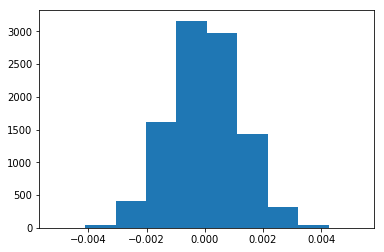

In [31]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [32]:
# Computing the treatment convertion rate and the control convertion rate from the df2- cleaned dataframe from ab_data.csv
treatment_convrate= df2.query('group == "treatment"')['converted'].mean()
control_convrate= df2.query('group == "control"')['converted'].mean()

# Computing the actual difference
actual_diff= treatment_convrate - control_convrate
print(treatment_convrate, control_convrate, actual_diff)

0.11880806551510564 0.1203863045004612 -0.0015782389853555567


 Let us look at where the actual difference can be seen in the sampling distribution under the null hypothesis which we just plotted

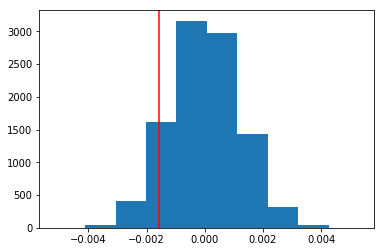

In [33]:
plt.hist(p_diffs);
plt.axvline(x=actual_diff, color='red');

Let us compute the proportion of p_diffs greater than the actual difference.

In [34]:
# Computing the pvalue
p_diffs= np.array(p_diffs)
pval= (p_diffs > actual_diff).mean()
print(pval)

0.906


k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

We computed the p-value of this hypothesis test in part j. All hypothesis tests ultimately use a p-value to weigh the strength of the evidence (what the data are telling you about the population). The p-value is a number between 0 and 1 and interpreted in the following way:  

A small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so you reject the null hypothesis.  
A large p-value (> 0.05) indicates weak evidence against the null hypothesis, so you fail to reject the null hypothesis.

**A p-value of 0.906, which is on the higher side for p-values indicate weak evidence against the null hypothesis. That is we fail to reject the null hypothesis which means the new page is doing just as same as the old page with respect to conversion rates.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [35]:
import statsmodels.api as sm

convert_old = df2.query('group=="control" and converted== 1').user_id.count()
convert_new = df2.query('group=="treatment" and converted== 1').user_id.count() 
n_old = df2.query('group == "control"')['converted'].count()
n_new = df2.query('group == "treatment"')['converted'].count()

print(convert_old, convert_new, n_old, n_new)

17489 17264 145274 145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [36]:
# This function returns the test statistic and the p-value for the z-test
z_stat,p_value= sm.stats.proportions_ztest([convert_old,convert_new],[n_old,n_new], alternative='smaller')
print(z_stat,p_value)

1.3109241984234394 0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**A z_score is the number of standard deviations the element is above or below the mean. In this case, the element is the mean of the conversion rates. With a z_score of 1.31 this means that this value lies between the 1st(~68% of the normal distribution lies between) and 2nd(~95% of the normal distribution) standard deviations and a positive value indicates that it lies above the mean.** 


**With a p_value of 0.9051(> 0.05(Type I error)) we accept the null hypothesis. That is the old_page is doing just as same or better than the new_page.**  

The above findings agree with those in part j and k.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**We should be performing Logistic Regression in this case because it is a regression approach used to predict a categorical response of only two possible outcomes. In our case, it's to find if there is a conversion or not.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [37]:
# Let us store our df2 dataframe in a csv before performing further operations on it
df2.to_csv('ab_clean_data.csv', index= False)

In [38]:
df2['intercept']= 1
df2['ab_page']= pd.get_dummies(df2['group'])['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [39]:
log_mod= sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results= log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [40]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 28 Jun 2019   Pseudo R-squ.:               8.077e-06
Time:                        18:08:17   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**The p-value associated with ab_page is 0.190. The p-value obtained from Part II was 0.906 (from simulation) and 0.90505 (from built-in statsmodels).**

**The null and alternative hypotheses associated with our regression model is as follows-**
$$H_0: p_{new} = p_{old}$$
$$H_1: p_{new} \neq p_{old}$$


**The difference between the two approaches is as follows-**

**In Part II, we were interested in finding if the conversion rate of the individuals from the treatment group were greater than that of the control group making it a One-tailed Test.**

**Here in Part III, we are interested in predicting if an individual converts to the new page or not making it a Two-tailed test.**


This explains the reason behind the difference between the p-values obtained from Part II and Part III. Also, depending on the direction of the one-tailed hypothesis, it's p-value is either 0.5*(two-tailed p-value) or 1-0.5*(two-tailed p-value). In our case-
1-(0.19\*0.5)= 0.905 which matches with the p-value of the One-tailed test calculated in Part II.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**The other factors that might influence whether or not an individual converts could be-**
* Age or Gender of the group of individuals.
* On examining the timestamp column, we find the entire experiment was run for 22 days. This timespan might also be too less to come to a conclusion.
* We might also get biased results if this test is run on an existing group because of 2 factors namely the-  
 * Change Aversion  
 * Novelty Effect

**Yes, there are disadvantages when adding additional terms into our regression model. Multicollinearity is a major disadvantage where in we want our explanatory variables to be correlated with the response and not with one another. This will make our model unstable and our predictions unreliable.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [41]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [42]:
##Checking the values in our dataframe df_new
df_new.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [43]:
# Checking our new dataframe for nulls and duplicates
df_new.isnull().sum()

country         0
timestamp       0
group           0
landing_page    0
converted       0
intercept       0
ab_page         0
dtype: int64

In [44]:
sum(df_new.duplicated())

0

We found no nulls and duplicates in the df_new dataframe.  
We will go ahead and create 3 dummy variable columns in the df_new dataframe and use only 2 of the columns, keeping the other as the baseline in our regression model to create matrices that are full rank.

In [45]:
df_new[['US','UK','CA']]= pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK,CA
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [46]:
## Considering CA as the baseline, let's fit our Logistic Regression model with only countries 
## as our explanatory variables and obtain the results.

log_mod2= sm.Logit(df_new['converted'], df_new[['intercept', 'US','UK']])
results2= log_mod2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 28 Jun 2019   Pseudo R-squ.:               1.521e-05
Time:                        18:42:45   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
US            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

In [47]:
# Let us take exponential of the co-efficients of US and UK variables to interpret the logistic regression results
np.exp(-0.0408), np.exp(0.0099)

(0.9600211149716509, 1.0099491671175422)

In [48]:
#Usually when results are less than 1, we take the reciprocal to interpret the results. So our final results are
1/np.exp(-0.0408), np.exp(0.0099)

(1.0416437559600236, 1.0099491671175422)

**Interpretting the logistic regression results-**  
* Users from US are 1.042 times likely to convert, holding all else constant.  
* Users from UK are 1.009 times likely to convert, holding all else constant.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [49]:
# Now let us fit our regression model using the ab_page along with countries US and UK as the explanatory variables

log_mod3= sm.Logit(df_new['converted'], df_new[['intercept','ab_page','US','UK']])
results3= log_mod3.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 28 Jun 2019   Pseudo R-squ.:               2.323e-05
Time:                        19:02:35   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [50]:
# Let us take exponential of the co-efficients of the explanatory to interpret the Logistic regression results.
np.exp(-0.0149), np.exp(-0.0408), np.exp(0.0099)

(0.9852104557227469, 0.9600211149716509, 1.0099491671175422)

In [51]:
## For values that are less than 1, we take the reciprocal to interpret the results. So our final results are-
1/np.exp(-0.0149), 1/np.exp(-0.0408), np.exp(0.0099)

(1.0150115583846535, 1.0416437559600236, 1.0099491671175422)

**Interpretting the above results is as follows-**  
* For every unit decrease in new_page, conversion is 1.051 times as likely holding all else constant.
* Users from US are 1.042 times likely to convert, holding all else constant.  
* Users from UK are 1.009 times likely to convert, holding all else constant.
* Also, since p-values of all the co-efficients are greater than 0.05 we would strongly consider the null hypothesis and conclude that the new page is not significantly better than the old page.

In order to understand the interaction between page and country and to see if there are any significant effects on conversion let us create the necessary additional columns and fit the new model. 

In [53]:
# Let us have a look at the our dataframe
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK,CA
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [54]:
# In order to understand the interaction between the page and country variables, 
# lets us create columns for the interaction variables as follows
df_new['US_ab_page']= df_new['US'] * df_new['ab_page']
df_new['UK_ab_page']= df_new['UK'] * df_new['ab_page']

In [55]:
# And now our dataframe looks like this-
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK,CA,US_ab_page,UK_ab_page
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,1


In [56]:
# Now let us fit our regression model for country US using the ab_page along with US and US_ab_page variables
log_mod4= sm.Logit(df_new['converted'], df_new[['intercept','ab_page','US','US_ab_page']])
results4= log_mod4.fit()
results4.summary()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 30 Jun 2019   Pseudo R-squ.:               2.567e-05
Time:                        00:05:30   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1409
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9880      0.008   -240.457      0.000      -2.004      -1.972
ab_page       -0.0123      0.012     -1.049      0.294      -0.035       0.011
US            -0.0160      0.037     -0.429      0.668      -0.089       0.057
US_ab_page    -0.0552      0.053     -1.034      0.301      -0.160       0.049
==============================================================================
"""

In [57]:
# Taking the exponential of the coefficients to interpret them
np.exp(-0.0123), np.exp(-0.0160), np.exp(-0.0552)

(0.9877753358068531, 0.9841273200552851, 0.9462958698523343)

In [58]:
# For values that are less than 1, we take the reciprocal to interpret the results. So our final results are-
1/np.exp(-0.0123), 1/np.exp(-0.0160), 1/np.exp(-0.0552)

(1.0123759561005452, 1.0161286854060947, 1.0567519439306503)

**Interpretting the results for the page and country interaction for US is as follows-**  
* For every unit decrease in new page, conversion is 1.012 times as likely, holding all else constant.
* Users from US are 1.016 times likely to convert, holding all else constant.  
* For a decrease in every new page viewed by users from US, conversion is 1.056 times as likely, holding all else constant.
* Also, since p-values of all the co-efficients are greater than 0.05 we would strongly consider the null hypothesis and conclude that the new page is not significantly better than the old page.

**Hence, new page conversions has nothing to do with the users being from US.**

In [59]:
# Now let us fit our regression model for country UK using the ab_page along with UK and UK_ab_page variables
log_mod5= sm.Logit(df_new['converted'], df_new[['intercept','ab_page','UK','UK_ab_page']])
results5= log_mod5.fit()
results5.summary()

Optimization terminated successfully.
         Current function value: 0.366114
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 30 Jun 2019   Pseudo R-squ.:               2.036e-05
Time:                        00:18:28   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.2278
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9876      0.009   -213.551      0.000      -2.006      -1.969
ab_page       -0.0236      0.013     -1.788      0.074      -0.050       0.002
UK            -0.0046      0.019     -0.247      0.805      -0.041       0.032
UK_ab_page     0.0345      0.026      1.307      0.191      -0.017       0.086
==============================================================================
"""

In [60]:
# Taking the exponential of the coefficients to interpret them
np.exp(-0.0236), np.exp(-0.0046), np.exp(0.0345)

(0.976676302155084, 0.9954105637959723, 1.0351020283761143)

In [61]:
# For values that are less than 1, we take the reciprocal to interpret the results. So our final results are-
1/np.exp(-0.0236), 1/np.exp(-0.0046), np.exp(0.0345)

(1.023880683695766, 1.0046105962413399, 1.0351020283761143)

**Interpretting the results for the page and country interaction for UK is as follows-**  
* For every unit decrease in new page, conversion is 1.023 times as likely, holding all else constant.
* Users from UK are 1.0046 times likely to convert, holding all else constant.  
* For a increase in every new page viewed by users from UK, conversion is 1.035 times as likely, holding all else constant.
* Though the positive value for the UK_ab_page co-effiecient gives us the idea that conversion rate(response) increases with increase in every UK user veiwing the new page, the p-values are not promising since they are all greater than 0.05.

**Though we see an increase in conversions for an increase in every new page viewed by users from UK; since there are no significant p-values for any of the explanatory variables we have to agree that new page conversions has nothing to do with users from UK.**

<a id='conclusions'></a>
## Conclusions

**Based on the Hypothesis Tests, z-tests and Logistic Regression Models we do not see any significant results favouring the new page implementation. Also, the p-values calculated from all these tests showed us to strongly consider the null hypothesis respectively.**  

**The impact of the users being from different countries is also not very significant in proving the new page conversions vs the old page.**

**Hence we can conclude that the company can keep the old page, which is just as good as the new page.**

**Resources include Google, Youtube, Stackoverflow and Python Documentation and loads of Statistics related sites.**

In [62]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_AB_test_results.ipynb'])

0